# Overview: Project 3
#### author: L. Saetta
#### last update: 30/01/2021

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [179]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import random as rn
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae

# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable

# added by L.S
import seaborn as sns
sns.set()

# from student_utils
from student_utils import count_unique_values, show_dist, plot_hist_numerical, count_missing_values, count_zeros
from student_utils import reduce_dimension_ndc, patient_dataset_splitter, select_first_encounter, create_tf_categorical_feature_cols, compute_area

pd.set_option('display.max_columns', 500)

# to not display deprecation warnings and futurewarnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# to add reproducibility for TF results
SEED = 1234

os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(SEED)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(SEED)

tf.random.set_seed(SEED)

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [4]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [5]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [6]:
# substitude Nan in ndc_code with ? for uniformity
condition = df['ndc_code'].isna()

df.loc[condition, 'ndc_code'] = '?'

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [7]:
print('Number of records:', df.shape[0])

print('Number of distinct encounter:', df['encounter_id'].nunique())

Number of records: 143424
Number of distinct encounter: 101766


**Response 1**: the dataset is at **line level**. There are 143424 rows and only 101766 distinct encounter_id, therefore for some encounter_id we have more than 1 rows.

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

### compute num of missing values

In [8]:
# field with high number of missing value

# we have missing values in: race, weight, payer_code, medical_specialty, other_diagnosis_code, ndc_code, max_glu_serum, A1CResult

# fields where missing values have been codified as ?
vet_col = ['race', 'weight', 'payer_code', 'medical_specialty', 'ndc_code', 
       'other_diagnosis_codes','max_glu_serum','A1Cresult']
# char used to code null
vet_char_null = ['?','?','?','?','?', '?|?', 'None', 'None']

# in student_utils
df_null = count_missing_values(df, vet_char_null, vet_col)

df_null.head(len(vet_col))

,columns,# of nulls,perc
0,race,3309,2.3
1,weight,139122,97.0
2,payer_code,54190,37.8
3,medical_specialty,69463,48.4
4,ndc_code,23462,16.4
5,other_diagnosis_codes,340,0.2
6,max_glu_serum,136409,95.1
7,A1Cresult,117650,82.0


### compute num. of zeros

In [9]:
# field with high number of zeros

vet_col = ['number_inpatient', 'number_outpatient', 'number_emergency', 'num_lab_procedures', 'num_procedures', 
       'number_diagnoses', 'num_medications']

# in student_utils
df_zeros = count_zeros(df, vet_col)

df_zeros.head(len(vet_col))

,columns,# of zeros,perc
0,number_inpatient,96698,67.4
1,number_outpatient,120027,83.7
2,number_emergency,127444,88.9
3,num_lab_procedures,0,0.0
4,num_procedures,65788,45.9
5,number_diagnoses,0,0.0
6,num_medications,0,0.0


### Comment: we have 3 columns where the percentage of missing values is > 50%.

We will drop these columns (weight, max_glu_serum, A1Cresult) , not considering them for the regression model

### Comment: we have some numerical features with a high percentage of zeros (number_inpatients, outpatients, emergency, num_procedure) but probably this is not sign of missing values coded as zero.

### Compute cardinality of categorical columns

In [10]:
cat_feature_list = ['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                    'payer_code', 'medical_specialty', 
                    'primary_diagnosis_code', 'other_diagnosis_codes', 
                            'ndc_code', 'max_glu_serum', 'A1Cresult','change', 'readmitted']

# in student_utils
count_unique_values(df, cat_feature_list)

,column,cardinality
race,race,6
gender,gender,3
age,age,10
weight,weight,10
admission_type_id,admission_type_id,8
discharge_disposition_id,discharge_disposition_id,26
admission_source_id,admission_source_id,17
payer_code,payer_code,18
medical_specialty,medical_specialty,73
primary_diagnosis_code,primary_diagnosis_code,717


### Comment: we have several field with high and very high cardinality: medical_specialty, primary_diagnosis_code, other_diagnosis_code, ndc_code

### analyze distribution of numerical columns (features + time_in_hospital)

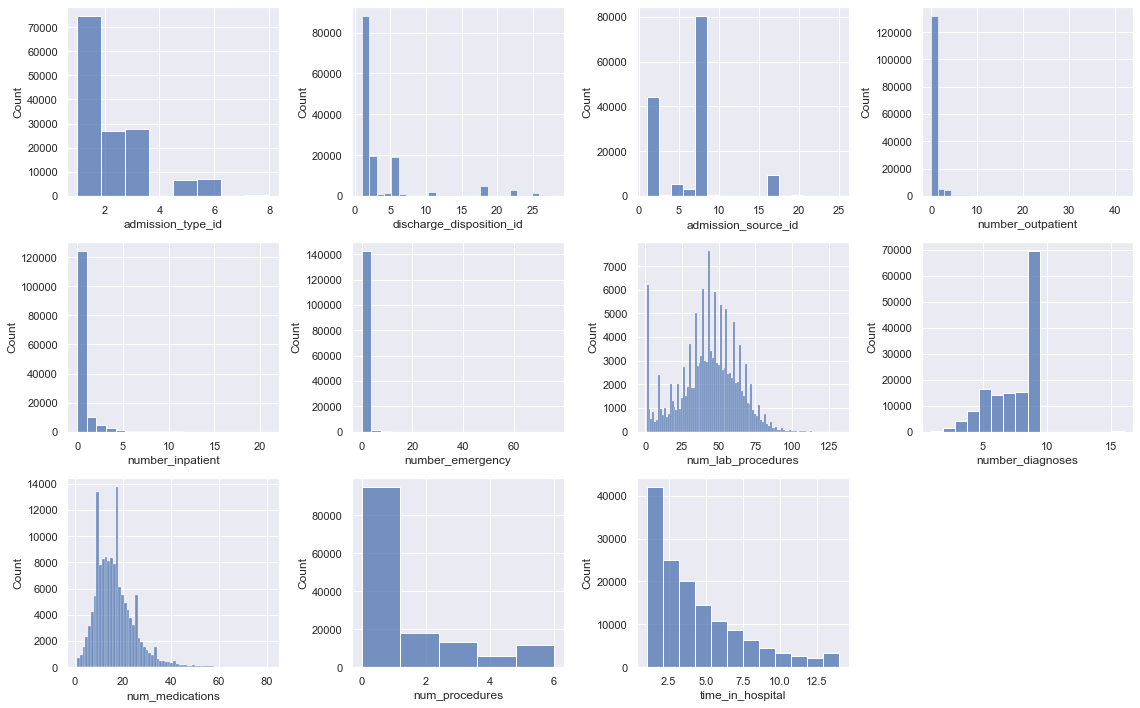

In [11]:
# compute histograms for each numerical field

numerical_feature_list = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
                          'number_outpatient', 'number_inpatient', 'number_emergency', 
                          'num_lab_procedures',
                         'number_diagnoses', 'num_medications', 'num_procedures', 'time_in_hospital']

# number of bins for corresponding hist.
vet_bins = [8, 26, 16, 30, 20, 20, 100, 16, 70, 5, 12]



plot_hist_numerical(df, numerical_feature_list, vet_bins)

### Comment: num_lab_procedures, num_medications have a gaussian distribution. For no columns ditribution is uniform

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [12]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [13]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [14]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [15]:
# first encounter for a patient is the encounter with lowest encounter_id
first_encounter_df = select_first_encounter(reduce_dim_df)

In [16]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print('')
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518

Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [17]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

In [18]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response: **weight** is missing in more than 97%. It is unpleasant because it could be a feature correlated to the length of hospitalization (higher the weight more severe the diabetes). **payer_code** is missing in 38%. I don't think it has much to do with the severity of the case and required hospitalization time. We can choose to remove it.

In [19]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']

# for now I remove primary_diagnosis_code and other_diagnosis_cod for their high cardinalidy
# that would require an approach diferent from one-hot encoding
# student_categorical_col_list = [ 'primary_diagnosis_code', 'other_diagnosis_codes', 'change', 
student_categorical_col_list = [ 'change', 
                                'readmitted' ] + required_demo_col_list + ndc_col_list
student_numerical_col_list = [ 'number_outpatient', 'number_inpatient', 'number_emergency',
                             'num_lab_procedures', 'number_diagnoses', 'num_medications',
                             'num_procedures']

PREDICTOR_FIELD = 'time_in_hospital'

In [20]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]

In [21]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [22]:
%autoreload

processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [23]:
%autoreload

d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

Number of records in Train 42910 , fraction is: 60.0 %
Number of records in Validation 14304 , fraction is: 20.0 %
Number of records in Test 14304 , fraction is: 20.0 %


In [24]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [25]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


In [27]:
# check that there is no intersection between train, test, validation on patient_nbr

# train, validation: check there are no common patients
assert len(set(d_train['patient_nbr']).intersection(set(d_val['patient_nbr']))) == 0

# train, test
assert len(set(d_train['patient_nbr']).intersection(set(d_test['patient_nbr']))) == 0

# val, test
assert len(set(d_val['patient_nbr']).intersection(set(d_test['patient_nbr']))) == 0

print("Test passed for no intersection on patient_nbr between train, validation and test set")

Test passed for no intersection on patient_nbr between train, validation and test set


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

#### entire (global) dataset, before splitting

time_in_hospital
1.0     10717
2.0     12397
3.0     12701
4.0      9567
5.0      6839
6.0      5171
7.0      3999
8.0      2919
9.0      1990
10.0     1558
11.0     1241
12.0      955
13.0      795
14.0      669
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


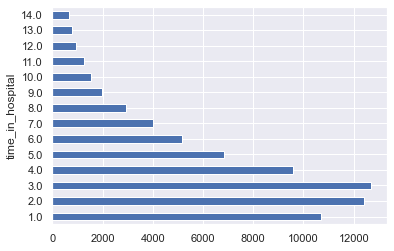

In [28]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

#### train dataset

time_in_hospital
1.0     6411
2.0     7391
3.0     7607
4.0     5750
5.0     4113
6.0     3128
7.0     2367
8.0     1794
9.0     1218
10.0     952
11.0     708
12.0     581
13.0     487
14.0     403
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


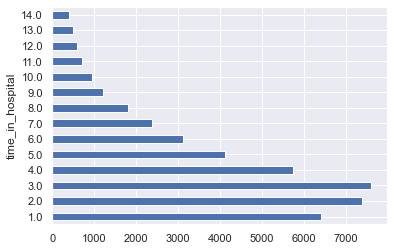

In [29]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

#### validation dataset

time_in_hospital
1.0     2113
2.0     2522
3.0     2533
4.0     1878
5.0     1391
6.0     1023
7.0      825
8.0      595
9.0      400
10.0     296
11.0     268
12.0     166
13.0     161
14.0     133
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


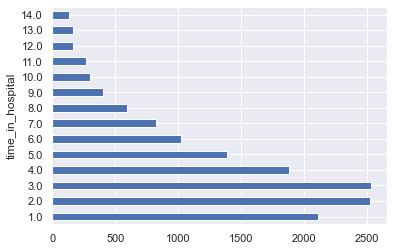

In [30]:
show_group_stats_viz(d_val, PREDICTOR_FIELD)

#### test dataset

time_in_hospital
1.0     2193
2.0     2484
3.0     2561
4.0     1939
5.0     1335
6.0     1020
7.0      807
8.0      530
9.0      372
10.0     310
11.0     265
12.0     208
13.0     147
14.0     133
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


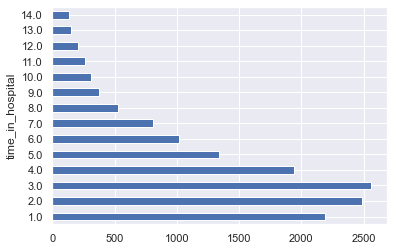

In [31]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

### Comment: the distribution of time_in_hospital is the same in all the datasets (train, validation, test). Most of the patients spend between 1-4 days in hospital. From the point of view of the drug's study (requiring 5-7 days) this means that not all the patients are good candidate. But we have in each datasets thousands of patients spending more than 5 days. 

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

### entire dataset: distribution of gender

gender
Female             38025
Male               33490
Unknown/Invalid        3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


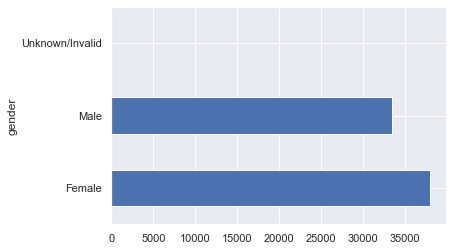

In [32]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

### train dataset

gender
Female    22779
Male      20131
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


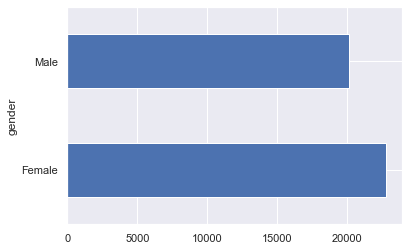

In [34]:
# Training partition
show_group_stats_viz(d_train, 'gender')

### validation dataset

gender
Female             7566
Male               6737
Unknown/Invalid       1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


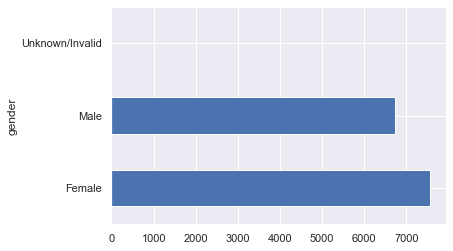

In [35]:
# validation partition
show_group_stats_viz(d_val, 'gender')

### test dataset

gender
Female             7680
Male               6622
Unknown/Invalid       2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


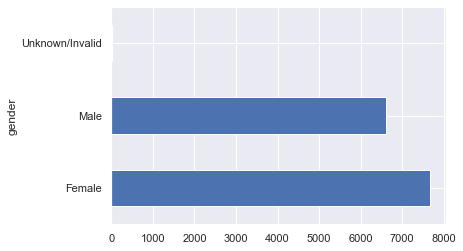

In [36]:
# Test partition
show_group_stats_viz(d_test, 'gender')

### the distribution for gender is the same in the three dataset. There is a slight majority of women. For same (3) patients gender is unknown/unspecified/other

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [37]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128

diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [38]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]

def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [39]:
# create the dir before
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [40]:
student_categorical_col_list

['change',
 'readmitted',
 'race',
 'gender',
 'age',
 'Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Glyburide-metformin_Hydrochloride',
 'Human_Insulin',
 'Insulin_Human',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Miglitol',
 'NA',
 'Nateglinide',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Repaglinide',
 'Rosiglitazone_Maleate',
 'Tolazamide',
 'Tolbutamide']

In [42]:
%autoreload

tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

In [43]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='change', vocabulary_file='./diabetes_vocab/change_vocab.txt', vocabulary_size=3, num_oov_buckets=1, dtype=tf.string, default_value=-1))
tf.Tensor(
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0.

# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [44]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [45]:
%autoreload

def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)

        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [46]:
%autoreload

tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [47]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='number_outpatient', shape=(1,), default_value=(0,), dtype=tf.float32, normalizer_fn=<function normalize_numeric_with_zscore.<locals>.norm_func at 0x7f974849f320>)

tf.Tensor(
[[-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [ 0.6930921 ]
 [-0.26764515]
 [-0.26764515]
 [ 0.6930921 ]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [ 0.6930921 ]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [ 0.6930921 ]
 [-0.26764515]
 [-0.26764515]
 [ 0.6930921 ]
 [-0.26764515]
 [ 1.6538293 ]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [ 0.6930921 ]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [-0.26764515]
 [ 0.6930921 ]
 [-0.26764515]


# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [48]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns, name='layer0')

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [49]:
import logging
# added to remove TF warnings !
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
        
def build_sequential_model(feature_layer, n_units):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(n_units, activation='relu', name='layer1'),
        tf.keras.layers.Dropout(0.2),
        # I prefer same number in the layers... the NN will decide
        tf.keras.layers.Dense(n_units, activation='relu', name='layer2'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(n_units, activation='relu', name='layer3'),
        
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable, name='layer4'),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        , name='layer5'),
    ])
    return model

# separate build from train, because I need to save the weights with best val_mse (with the Checkpoint callback)
def build_diabetes_model(feature_layer, loss_metric='mse', n_units=128):
    print('')
    print('Training with n_units =', n_units)
    
    model = build_sequential_model(feature_layer, n_units)
    model.compile(optimizer='adam', loss=loss_metric, metrics=[loss_metric])
    
    return model

In [50]:
# from hyper-parameters' tuning work
N_UNITS = 192

tStart = time.time()

loss_metric='mse'

diabetes_model = build_diabetes_model(claim_feature_layer, n_units=N_UNITS)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=10, verbose=1)
    
sv = tf.keras.callbacks.ModelCheckpoint('model_prob', monitor='val_mse', verbose=1, save_best_only=True,
                                            save_weights_only=True, mode='min', save_freq='epoch')
    
history = diabetes_model.fit(diabetes_train_ds, validation_data=diabetes_val_ds,
                        callbacks=[early_stop, sv],
                        epochs=50, verbose=1)
    
tEla = round(time.time() - tStart, 1)
print('')
print('Elapsed time:', tEla)


Training with n_units = 192
Epoch 1/50
336/336 [==============================] - 7s 13ms/step - loss: 28.8099 - mse: 28.6759 - val_loss: 18.6576 - val_mse: 17.9347

Epoch 00001: val_mse improved from inf to 17.93468, saving model to model_prob
Epoch 2/50
336/336 [==============================] - 3s 8ms/step - loss: 17.3735 - mse: 16.6244 - val_loss: 13.7457 - val_mse: 12.6940

Epoch 00002: val_mse improved from 17.93468 to 12.69405, saving model to model_prob
Epoch 3/50
336/336 [==============================] - 3s 8ms/step - loss: 13.4465 - mse: 12.4786 - val_loss: 12.2542 - val_mse: 11.1877

Epoch 00003: val_mse improved from 12.69405 to 11.18767, saving model to model_prob
Epoch 4/50
336/336 [==============================] - 3s 8ms/step - loss: 12.0715 - mse: 11.1655 - val_loss: 11.3422 - val_mse: 10.4623

Epoch 00004: val_mse improved from 11.18767 to 10.46234, saving model to model_prob
Epoch 5/50
336/336 [==============================] - 3s 9ms/step - loss: 10.9736 - mse: 10

In [51]:
def plot_loss(hist, skip):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['loss'][skip:], label='Training loss')
    plt.plot(hist.history['val_loss'][skip:], label='Validation loss')
    plt.title('Loss')
    plt.legend(loc='upper right')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid(True)
    plt.show();

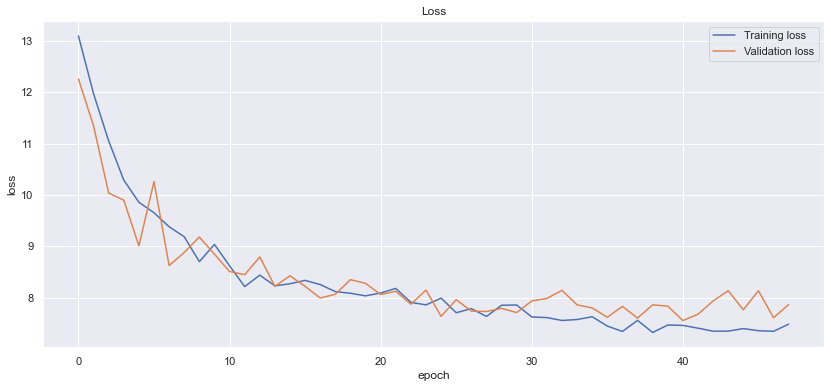

In [52]:
plot_loss(history, 2)

In [53]:
def plot_mse(hist, skip):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['mse'][skip:], label='Training mse')
    plt.plot(hist.history['val_mse'][skip:], label='Validation mse')
    plt.title('Mse')
    plt.legend(loc='upper right')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.grid(True)
    plt.show();

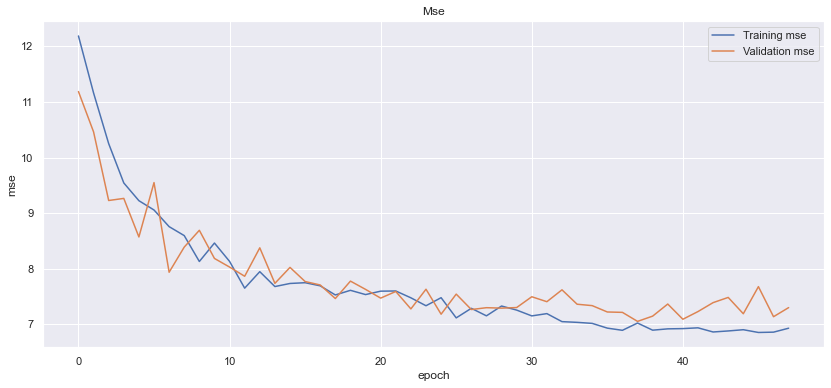

In [54]:
plot_mse(history, 2)

In [55]:
# loading best weights
print('Loading best model...')

diabetes_model = build_diabetes_model(claim_feature_layer,  n_units=N_UNITS)

diabetes_model.load_weights('model_prob')

Loading best model...

Training with n_units = 192


## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [56]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])

# diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [57]:
%autoreload

from student_utils import get_mean_std_from_preds

# every time I apply the model I have a different value, for the DenseVariational layer
# therefore I need to average
# see: https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html
N = 512

avg_m = 0. 
avg_s = 0.

for i in range(N):
    diabetes_yhat = diabetes_model(diabetes_x_tst)
    m, s = get_mean_std_from_preds(diabetes_yhat)
    avg_m += m
    avg_s += s

avg_m = avg_m/tf.cast(N, tf.float32)
avg_s = avg_s/tf.cast(N, tf.float32)

## Show Prediction Output 

In [58]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": avg_m.numpy().flatten(),
    "pred_std": avg_s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [59]:
prob_output_df.head(20)

,pred,actual_value,pred_mean,pred_std
0,2.193155,1.0,3.598635,0.693628
1,5.317574,2.0,3.209491,0.693594
2,7.536895,4.0,2.920343,0.693566
3,6.486522,4.0,4.298427,0.693599
4,3.687894,12.0,7.204350,0.693632
5,8.032022,3.0,2.641346,0.693558
6,3.932108,2.0,2.616347,0.693550
7,7.389812,1.0,2.405956,0.693556
8,4.710483,1.0,3.435714,0.693585
9,4.331904,4.0,2.738413,0.693562


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [64]:
%autoreload

from student_utils import get_student_binary_prediction

# modified intrdoucing. a threshold
# the value used here for the threshold (4.6) is justified for the computation done for question 11 (see below)
# It is the threshold that maximizes the F1-score
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean', threshold=4.6)

get_student_binary_prediction---> Predicted positive: 4806


### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [61]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [131]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head(10)

,patient_nbr,gender,race,time_in_hospital,score,label_value
42730,52603497,Male,Caucasian,1.0,0,0
33088,40451508,Female,Caucasian,2.0,0,0
44619,38807748,Male,Caucasian,4.0,0,0
18705,1349262,Female,?,4.0,0,0
33430,106664841,Female,Caucasian,12.0,1,1
23696,17841375,Female,Caucasian,3.0,0,0
43350,97396200,Male,AfricanAmerican,2.0,0,0
70777,132368810,Female,Caucasian,1.0,0,0
8395,23385321,Female,Caucasian,1.0,0,0
36287,92532573,Female,Caucasian,4.0,0,0


#### the dataframe is ready for using **AEquitas** toolkit. It has score and label_value. Attribute to be used for bias analysis are: gender and race

## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [171]:
%autoreload
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# do the computation for different thresholds
threshold_list = [round(thr, 1) for thr in np.arange(2.0, 6.0, 0.20)] 

acc_list = []
prec_list = []
rec_list = []
f1_list = []
conf_mat_list = []
tpr_list = []
fpr_list = []

for thr in threshold_list:
    print('Compute for THRESHOLD:', thr)
    
    student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean', threshold=thr)
    
    pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])
    
    y_true = pred_test_df['label_value'].values
    y_preds = pred_test_df['score'].values
    
    conf_mat = confusion_matrix(y_true, y_preds)
    tn, fp, fn, tp = conf_mat.ravel()
    
    acc = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='weighted')
    recall = recall_score(y_true, y_preds, average='weighted')
    f1 = f1_score(y_true, y_preds, average='weighted')
    tpr = round(tp/float(tp + fn), 2)
    fpr = round(fp/float(fp + tn), 2)
    
    acc_list.append(acc)
    prec_list.append(precision)
    rec_list.append(recall)
    f1_list.append(f1)
    conf_mat_list.append([tn, fp, fn, tp])
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    
# build the results dataframe
stats_df = pd.DataFrame(list(zip(threshold_list, conf_mat_list, acc_list, prec_list, rec_list, f1_list)), 
               columns =['thr', 'conf_mat [tn, fp, fn, tp]', 'acc', 'prec', 'rec', 'f1'])

Compute for THRESHOLD: 2.0
get_student_binary_prediction---> Predicted positive: 14304
Compute for THRESHOLD: 2.2
get_student_binary_prediction---> Predicted positive: 13555
Compute for THRESHOLD: 2.4
get_student_binary_prediction---> Predicted positive: 12631
Compute for THRESHOLD: 2.6
get_student_binary_prediction---> Predicted positive: 11898
Compute for THRESHOLD: 2.8
get_student_binary_prediction---> Predicted positive: 11155


/Users/lsaetta/opt/anaconda3/envs/udacity-ehr-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Compute for THRESHOLD: 3.0
get_student_binary_prediction---> Predicted positive: 10395
Compute for THRESHOLD: 3.2
get_student_binary_prediction---> Predicted positive: 9593
Compute for THRESHOLD: 3.4
get_student_binary_prediction---> Predicted positive: 8828
Compute for THRESHOLD: 3.6
get_student_binary_prediction---> Predicted positive: 8109
Compute for THRESHOLD: 3.8
get_student_binary_prediction---> Predicted positive: 7455
Compute for THRESHOLD: 4.0
get_student_binary_prediction---> Predicted positive: 6805
Compute for THRESHOLD: 4.2
get_student_binary_prediction---> Predicted positive: 6165
Compute for THRESHOLD: 4.4
get_student_binary_prediction---> Predicted positive: 5515
Compute for THRESHOLD: 4.6
get_student_binary_prediction---> Predicted positive: 4806
Compute for THRESHOLD: 4.8
get_student_binary_prediction---> Predicted positive: 4088
Compute for THRESHOLD: 5.0
get_student_binary_prediction---> Predicted positive: 3631
Compute for THRESHOLD: 5.2
get_student_binary_predict

In [172]:
stats_df.head(len(threshold_list))

,thr,"conf_mat [tn, fp, fn, tp]",acc,prec,rec,f1
0,2.0,"[0, 9177, 0, 5127]",0.358431,0.128473,0.358431,0.189149
1,2.2,"[712, 8465, 37, 5090]",0.405621,0.744469,0.405621,0.287353
2,2.4,"[1555, 7622, 118, 5009]",0.458893,0.738459,0.458893,0.386102
3,2.6,"[2198, 6979, 208, 4919]",0.497553,0.734291,0.497553,0.450611
4,2.8,"[2837, 6340, 312, 4815]",0.534955,0.732718,0.534955,0.507326
5,3.0,"[3475, 5702, 434, 4693]",0.571029,0.732158,0.571029,0.557478
6,3.2,"[4110, 5067, 601, 4526]",0.603747,0.728830,0.603747,0.600146
7,3.4,"[4708, 4469, 768, 4359]",0.633879,0.728572,0.633879,0.636191
8,3.6,"[5259, 3918, 936, 4191]",0.660654,0.729884,0.660654,0.665966
9,3.8,"[5722, 3455, 1127, 4000]",0.679670,0.728316,0.679670,0.686039


### Plots

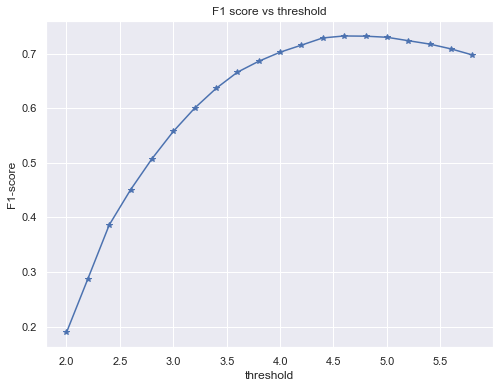

In [173]:
# plot the f1 score vs threshold
plt.figure(figsize=(8, 6))
plt.plot(threshold_list, f1_list, '*-')
plt.title('F1 score vs threshold')
plt.xlabel('threshold')
plt.ylabel('F1-score')
plt.grid(True)
plt.show()

### from this plot we clearly see that for threshold = 4.6 the f1-score is maximum

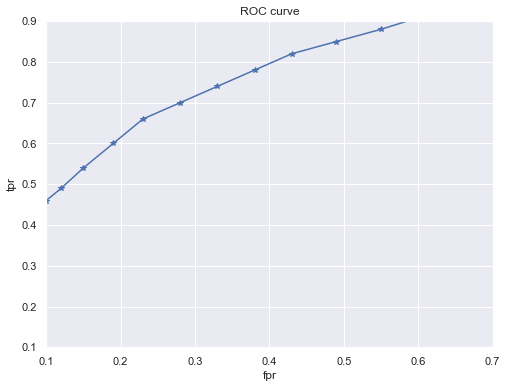

In [174]:
# plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_list, tpr_list, '*-')
plt.title('ROC curve')
plt.xlim((0.1, 0.7))
plt.ylim((0.1, 0.9))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.grid(True)
plt.show()

In [180]:
# compute ROC AUC
fpr_list_reverse = list(reversed(fpr_list))
tpr_list_reverse = list(reversed(tpr_list))

area = compute_area(fpr_list_reverse, tpr_list_reverse)

print('ROC AUC: ', area)

ROC AUC:  0.77


### TODO add summary here

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [132]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

# we take only needed cols
ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]

ae_df, _ = preprocess_input_df(ae_subset_df)

g = Group()
xtab, _ = g.get_crosstabs(ae_df)

In [ ]:
# a first result fpr and fnr are much different in hispanic than not in other races

In [134]:
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

In [135]:
# get a first idea
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,?,0.41,0.94,0.26,0.22,0.06,0.59,0.74,0.78,0.03,0.19,0.36
1,race,AfricanAmerican,0.34,0.94,0.28,0.23,0.06,0.66,0.72,0.77,0.18,0.16,0.36
2,race,Asian,0.30,0.95,0.23,0.31,0.05,0.70,0.77,0.69,0.01,0.12,0.28
3,race,Caucasian,0.35,0.94,0.28,0.22,0.06,0.65,0.72,0.78,0.75,0.16,0.36
4,race,Hispanic,0.27,0.95,0.25,0.28,0.05,0.73,0.75,0.72,0.01,0.11,0.30
5,race,Other,0.45,0.94,0.20,0.24,0.06,0.55,0.80,0.76,0.02,0.18,0.30
6,gender,Female,0.34,0.94,0.29,0.22,0.06,0.66,0.71,0.78,0.55,0.17,0.37
7,gender,Male,0.36,0.94,0.26,0.23,0.06,0.64,0.74,0.77,0.45,0.16,0.34
8,gender,Unknown/Invalid,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.50,0.50


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [ ]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

In [ ]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

In [ ]:
# Reference group fairness plot